# Run Pyro spatialVAE on rotated MNIST dataset

In [1]:
import sys
sys.path.append('../models')

from typing import Optional, Tuple, Type, Union

import hydra
#from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.experimental import compose, initialize
import logging
import os
import numpy as np
import os.path as osp

import torch
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from functools import reduce
import operator

import pyro
import pyro.distributions as dist

from dm_mnist import MnistRotate
from vae import VAE
from pyroVAE import PyroVAE, SVITrainer
from omegaconf import OmegaConf
logger = logging.getLogger(__name__)

/Users/ckapoura/anaconda3/envs/vae/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


# Load settings and data

In [2]:
with initialize(config_path="../configs"):
    cfg = compose(config_name="spatialVAE_mnist.yaml")
    print(cfg)
out_dir = osp.join("..", "output")

{'dataset': 'mnist', 'likelihood': 'bernoulli', 'z_dim': 8, 'hidden_dim': 256, 'num_layers': 2, 'activation': 'tanh', 'modify': 1, 'kl_coef': 1.0, 'lr': 0.0001, 'step_size': 25, 'batch_size': 64, 'num_workers': 2, 'num_epochs': 100, 'seed': 123, 'fast_dev_run': False, 'dx_scale': 0.1, 'theta_prior': 0.7854}


In [3]:
# Dataset
mnist_train_data = MnistRotate(root = osp.join('..', 'data'), dataset_name="MNIST",
                         train = True, modify=cfg.modify, 
                         transform=transforms.Compose([transforms.ToTensor()]))
mnist_train_loader = DataLoader(mnist_train_data, batch_size=cfg.batch_size, shuffle=True)

# Extract each component of the dataset in a different variable
angles = []
train_labels = []
train_data = torch.zeros([0, 1, 28, 28])
for datum, label, angle in mnist_train_loader:
    angles.append(angle.tolist())
    train_labels.append(label.tolist())
    train_data = torch.cat((train_data, datum), 0)

angles = reduce(operator.concat, angles)
train_labels = reduce(operator.concat, train_labels)
train_data = torch.squeeze(train_data)
# Create data loader
def init_dataloader(*args: torch.Tensor, **kwargs: int
                    ) -> Type[torch.utils.data.DataLoader]:

    batch_size = kwargs.get("batch_size", 64)
    shuffle = kwargs.get("shuffle", True)
    tensor_set = torch.utils.data.dataset.TensorDataset(*args)
    data_loader = torch.utils.data.DataLoader(
        dataset=tensor_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader

train_loader = init_dataloader(train_data, batch_size=cfg.batch_size, shuffle=True)

/Users/ckapoura/Research/Projects/yau/spatialDGM/code/spatialDGM/notebooks/../models/dm_mnist.py:272: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


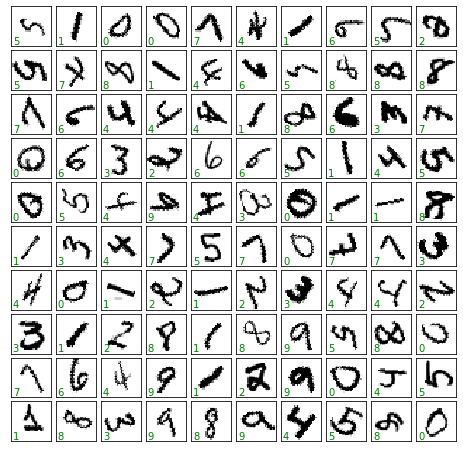

In [4]:
# Plot samples from dataset
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im, cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl),
            transform=ax.transAxes, color='green')

# Train vanilla VAE

## Train VAE model

In [5]:
# Size of each image
data_dim = (1, 28, 28)
# modify = 0, denotes simple VAE
cfg.modify = 0
cfg.z_dim = 2

# Initialize probabilistic VAE model
vae = PyroVAE(hparams=cfg, data_dim=data_dim)

# Initialize SVI trainer
trainer = SVITrainer(model=vae, seed=1234)

# Train for n epochs
for e in range(15):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 203.0212
Epoch: 2 Training loss: 186.0329
Epoch: 3 Training loss: 179.9058
Epoch: 4 Training loss: 177.0874
Epoch: 5 Training loss: 175.0914
Epoch: 6 Training loss: 173.2267
Epoch: 7 Training loss: 172.1368
Epoch: 8 Training loss: 171.1845
Epoch: 9 Training loss: 170.7041
Epoch: 10 Training loss: 169.6905
Epoch: 11 Training loss: 169.1831
Epoch: 12 Training loss: 168.4446
Epoch: 13 Training loss: 168.1289
Epoch: 14 Training loss: 167.6853
Epoch: 15 Training loss: 167.7318


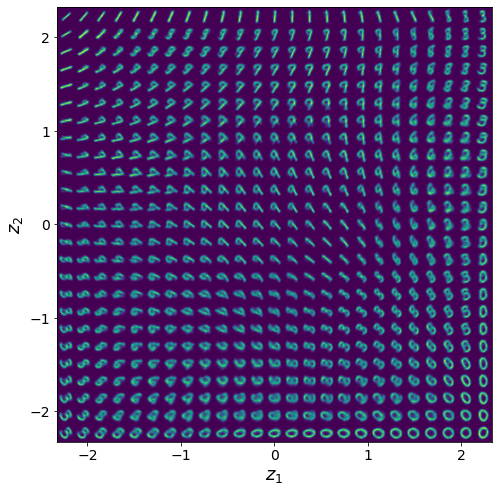

In [6]:
# Visualize the learned manifold
vae.manifold2d(d=25, cmap='viridis')

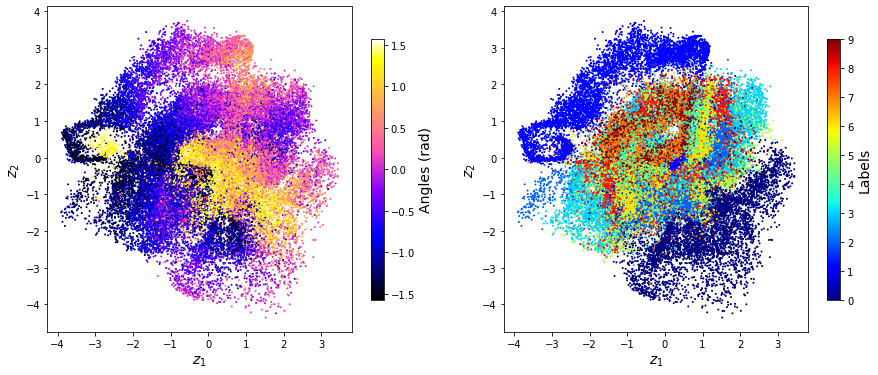

In [7]:
# View encoded data in 2-D
z_mean, z_sd = vae.encode(train_data, train_loader=train_loader)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))

im1 = ax1.scatter(z_mean[:,1], z_mean[:,0], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)

im2 = ax2.scatter(z_mean[:,1], z_mean[:,0], c=train_labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

In [ ]:
#save_file = osp.join(out_dir, 'vae_mnist_encoder.pth')
#torch.save(vae_model.q_net.state_dict(), save_file)
#save_file = osp.join(out_dir, 'vae_mnist_decoder.pth')
#torch.save(vae_model.p_net.state_dict(), save_file)

## Visualise example data

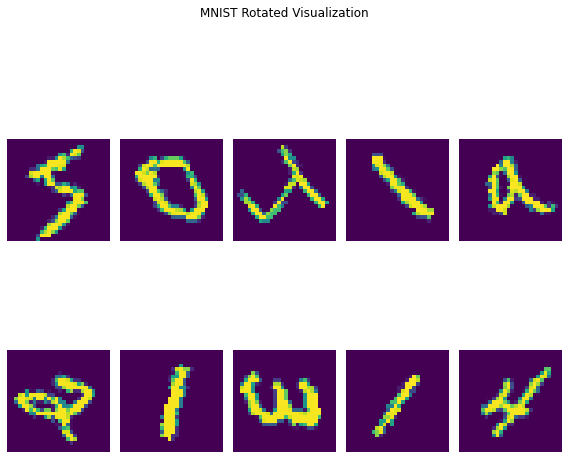

In [13]:
plt.rcParams['figure.figsize'] = [8, 8]

# Visualize rotated dataset
fig, axs = plt.subplots(2, 5)
for ax, i in zip(axs.flatten(), np.arange(0, 10)):
    img, _, angle = mnist_train_data[i]
    ax.imshow(img.squeeze())
    ax.set_axis_off()
fig.suptitle("MNIST Rotated Visualization")
plt.tight_layout()
plt.show()

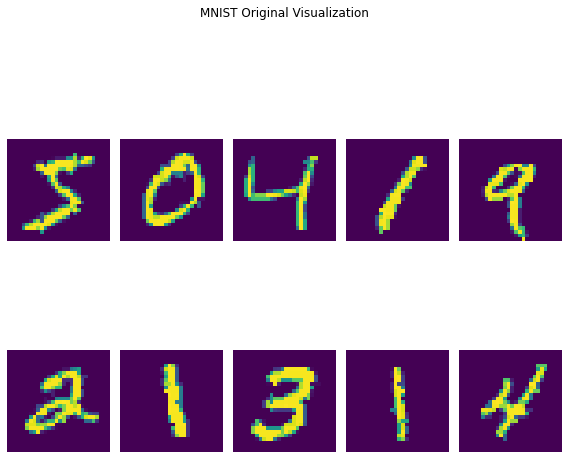

In [14]:
# Visualize original dataset
fig, axs = plt.subplots(2, 5)
for ax, i in zip(axs.flatten(), np.arange(0, 10)):
    img, _, angle = mnist_train_data[i]
    angle_deg = angle.item() * 180 / np.pi
    img = TF.rotate(img=img, angle=-angle_deg) 
    ax.imshow(img.squeeze())
    ax.set_axis_off()
fig.suptitle("MNIST Original Visualization")
plt.tight_layout()
plt.show()

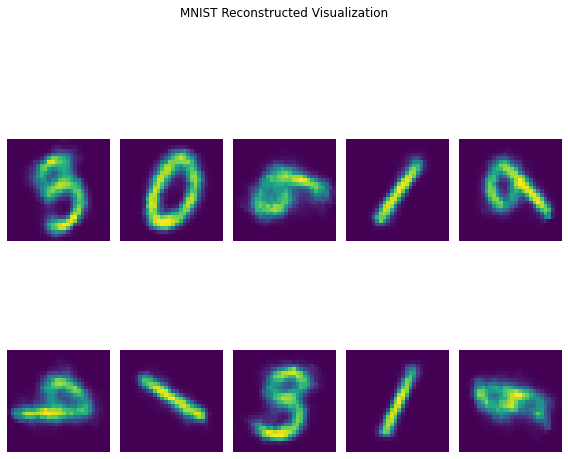

In [23]:
# VAE predictions
#vae.eval()
fig, axs = plt.subplots(2, 5)
for ax, i in zip(axs.flatten(), np.arange(0, 10)):
    img, _, angle = mnist_train_data[i]
    # First parameter of forward is y_hat: reconstructed input
    with torch.no_grad():
        z_loc, z_logscale, z_scale = vae.q_net(img)
        z = dist.Normal(z_loc, z_scale).sample()
        imgs_vae = vae.p_net(z)[0].detach().numpy()
    ax.imshow(imgs_vae.squeeze()) #cmap='gray'
    ax.set_axis_off()
fig.suptitle("MNIST Reconstructed Visualization")
plt.tight_layout()
plt.show()

## Latent space visualisation

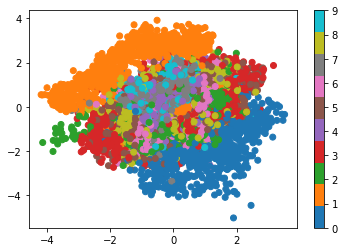

In [8]:
def plot_latent(vae, data, num_batches=100):
    z = np.zeros((num_batches+1, 2))
    target = []
    for i, (img, t, angle) in enumerate(data):
        # Second parameter of forward is z: latent space
        with torch.no_grad():
            z_loc, z_logscale, z_scale = vae.q_net(img)
            zz = dist.Normal(z_loc, z_scale).sample()
            z[i, :] = zz[0].detach().numpy()
        target.append(t)
        if i >= num_batches:
            break
    plt.scatter(z[:, 1], z[:, 0], c=target, cmap='tab10')
    plt.colorbar()
plot_latent(vae, mnist_train_data, num_batches=10000)

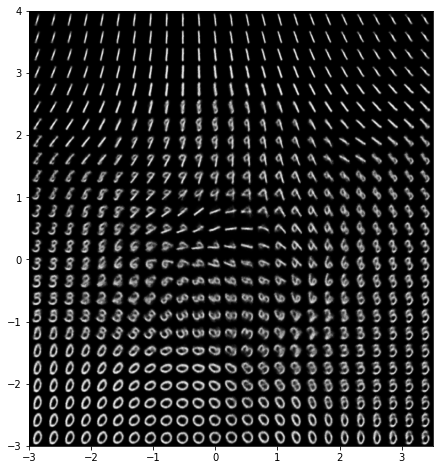

In [41]:
def plot_reconstructed(vae, r0=(-3, 3.5), r1=(-3, 4), n=15):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to('cpu')
            x_hat = vae.p_net(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gray')
plot_reconstructed(vae, n = 25)

## Interpolation

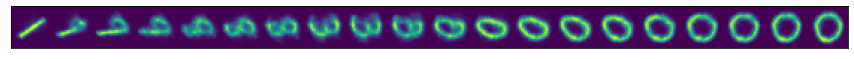

In [43]:
plt.rcParams['figure.figsize'] = [15, 20]
def interpolate(vae, x1, x2, n=12):
    with torch.no_grad():
        z_loc, z_logscale, z_scale = vae.q_net(x1)
        z1 = dist.Normal(z_loc, z_scale).sample()
        z_loc, z_logscale, z_scale = vae.q_net(x2)
        z2 = dist.Normal(z_loc, z_scale).sample()
    
    z = torch.stack([z1 + (z2 - z1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = vae.p_net(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

data = mnist_train_loader
x, y, k = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to('cpu') # find a 1
x_2 = x[y == 0][1].to('cpu') # find a 0

interpolate(vae, x_1, x_2, n=20)